In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image
import tensorflow as tf

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
def load_matrix(file):
    mat = np.genfromtxt('../derived-data/' + file, delimiter = ',')
    mat = mat[1:, ].astype(np.float32)
    return mat

Xtrain = load_matrix('Xtrain.csv')
Ytrain = load_matrix('Ytrain.csv')
Xtest = load_matrix('Xtest.csv')
Ytest = load_matrix('Ytest.csv')

In [3]:
n_features = Xtrain.shape[1]
n_classes = Ytrain.shape[1]

print(n_features, n_classes)

430 17


In [14]:
graph = tf.Graph()

n_hidden1 = 80
n_hidden2 = 50

def get_logits(X, w, b):
    hidden1 = tf.nn.relu(tf.matmul(X, w[0]) + b[0])
    hidden2 = tf.nn.relu(tf.matmul(hidden1, w[1]) + b[1])
    logits = tf.matmul(hidden2, w[2]) + b[2]
    return logits

with graph.as_default():
    # input data as constants
    tf_train_dataset = tf.constant(Xtrain)
    tf_train_labels = tf.constant(Ytrain)
    tf_test_dataset = tf.constant(Xtest)
    tf_test_labels = tf.constant(Ytest)
    beta_regul = tf.placeholder(tf.float32)
    
    # inputs -> hidden layer 1
    w1 = tf.Variable(tf.truncated_normal([n_features, n_hidden1]))
    b1 = tf.Variable(tf.zeros([n_hidden1]))
    
    # hidden layer 1 -> hidden layer 2
    w2 = tf.Variable(tf.truncated_normal([n_hidden1, n_hidden2]))
    b2 = tf.Variable(tf.zeros([n_hidden2]))
    
    # hidden layer 2 -> outputs
    w3 = tf.Variable(tf.truncated_normal([n_hidden2, n_classes]))
    b3 = tf.Variable(tf.zeros([n_classes]))
    
    w = [w1, w2, w3]
    b = [b1, b2, b3]
    
    # define loss function and optimization routine
    logits = get_logits(tf_train_dataset, w, b)
    
    # loss includes regularization to avoid overfitting
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + 
        beta_regul * (tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) + tf.nn.l2_loss(w3)))
    
    optimizer = tf.train.AdadeltaOptimizer(learning_rate=0.1, rho=0.95, 
                                           epsilon=1e-08, use_locking=False, 
                                           name='Adadelta').minimize(loss)
    
    # make predictions
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(get_logits(tf_test_dataset, w, b))

Initialized
Loss at step 0: 616.970032
Training accuracy: 3.1%
Test accuracy: 1.0%
Loss at step 2000: 137.183716
Training accuracy: 48.0%
Test accuracy: 41.4%
Loss at step 4000: 111.503563
Training accuracy: 51.2%
Test accuracy: 46.8%
Loss at step 6000: 93.700050
Training accuracy: 55.0%
Test accuracy: 50.2%
Loss at step 8000: 80.143204
Training accuracy: 57.0%
Test accuracy: 50.7%
Loss at step 10000: 69.745239
Training accuracy: 58.1%
Test accuracy: 54.2%
Loss at step 12000: 61.395966
Training accuracy: 60.7%
Test accuracy: 56.7%
Loss at step 14000: 54.541676
Training accuracy: 62.0%
Test accuracy: 57.6%
Loss at step 16000: 48.719505
Training accuracy: 63.2%
Test accuracy: 57.1%
Loss at step 18000: 43.654770
Training accuracy: 63.5%
Test accuracy: 58.1%
Loss at step 20000: 39.218685
Training accuracy: 64.6%
Test accuracy: 57.6%


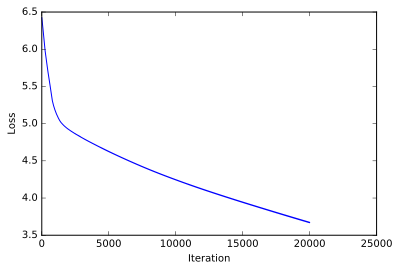

In [16]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])
feed_dict = {beta_regul : 1e-2}
loss_vec = []

# fit the model
num_steps = 20001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    _, l, predictions = session.run([optimizer, loss, train_prediction], 
                                   feed_dict = feed_dict)
    loss_vec.append(l)
    if (step % 2000 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(predictions, Ytrain))
      print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), Ytest))
    
# visualize loss over time
plt.plot([i + 1 for i in range(num_steps)], np.log(loss_vec))
plt.xlabel('Iteration')
plt.ylabel('Loss')